In [1]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
from scipy.io import loadmat
from time import time
import umap

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_samples, silhouette_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, completeness_score, homogeneity_score, mutual_info_score, rand_score, v_measure_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [2]:
# import the data
data_array = loadmat('./clustering_remotesensing-main/Data/Indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] # Hyperspectral data
gt = loadmat('./clustering_remotesensing-main/Data/Indian_pines/Indian_pines_gt.mat')['indian_pines_gt'] # Ground truth data

In [4]:
# visualisation
# read and enhance
def plot_array_stretched(array, label, n):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    cb = plt.imshow(array, cmap='Greys_r', vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    plt.colorbar(cb, shrink=1, label=label)
    plt.show()

@interact(band=range(1, data_array.shape[2]+1))
def show_dist(band):
    plot_array_stretched(data_array[:, :, band-1], f'Band {band}', 2)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

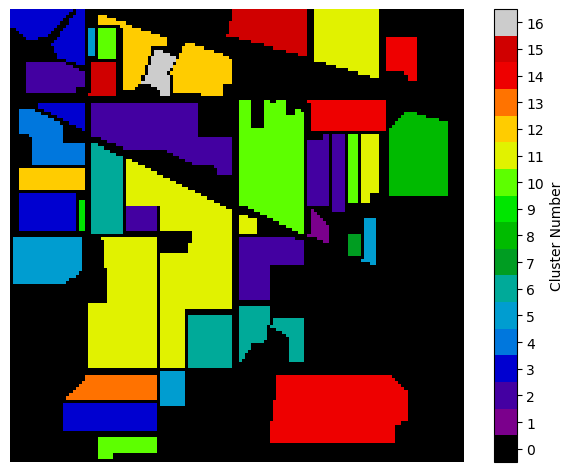

In [5]:
# Plot the gt
def plot_data(data, n_clusters):
    fig = plt.figure(figsize=(8, 6), dpi=100)
    plt.axis('off')
    cmap = cm.get_cmap('nipy_spectral', n_clusters)
    plt.imshow(data, cmap=cmap)
    cbar = plt.colorbar(label='Cluster Number')
    tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_clusters))
    
    plt.show()

plot_data(gt, 17)

In [6]:
# Reshape the input data from rcb to samples and features
data_reshaped = data_array.reshape(data_array.shape[0]*data_array.shape[1], -1)
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)
gt_reshaped = gt.flatten()

# Principal Component Analysis (PCA)

In [23]:
# PCA
pca = PCA()
components = pca.fit_transform(data_reshaped)
# eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

var_sum = 0
for i in range(len(var_ratio)):
    if var_sum >= 0.9:
        break
    else:
        var_sum += var_ratio[i]

selected_components_pca = components[:, :i]
print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected principal components: {i}')

Number of spectral bands: 200
Number of selected principal components: 2


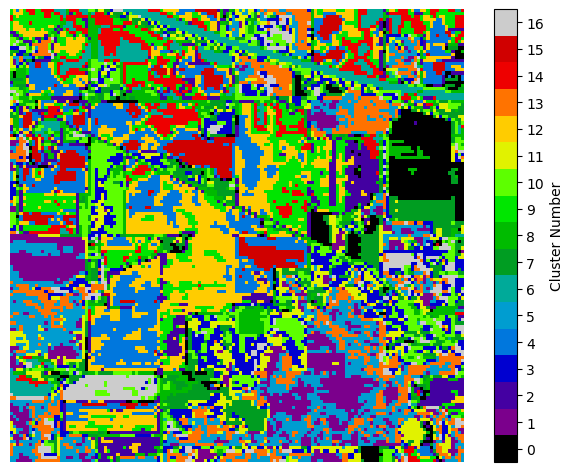

In [24]:
# k-means clustering using the components generated in the previous cell
clusterer = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = clusterer.fit_predict(selected_components_pca) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

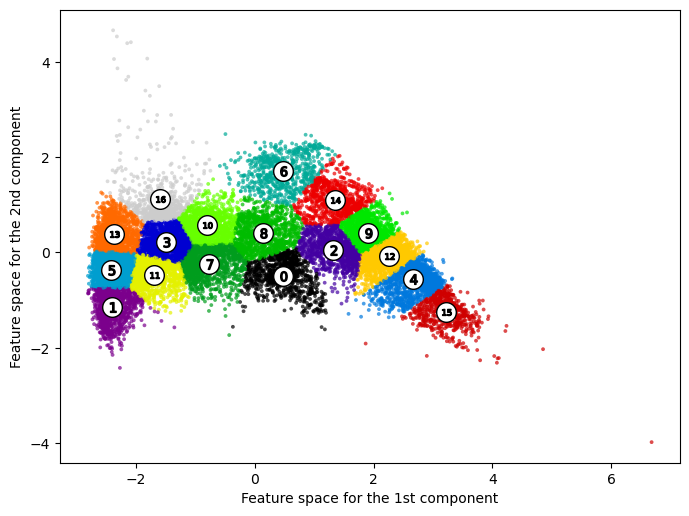

In [25]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components_pca[:, 0],
    selected_components_pca[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = clusterer.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

# plt.title('Clustered Data')
plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [26]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_pca = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialize the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components_pca)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components_pca, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components_pca, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components_pca, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_pca.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_pca.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.369762,41238.875944,0.815947,0.355945,0.245689,0.290714,0.695189,0.056849,0.650227,0.288964
16.0,0.360363,40801.475882,0.828143,0.358753,0.241576,0.288729,0.698069,0.059292,0.655356,0.286875
17.0,0.362289,40722.556225,0.809769,0.363130,0.238912,0.288206,0.697892,0.053435,0.663351,0.286252
18.0,0.365237,40445.652379,0.788400,0.366793,0.236163,0.287328,0.700278,0.055829,0.670044,0.285274
19.0,0.368905,40231.553336,0.791605,0.366809,0.236580,0.287641,0.697040,0.047972,0.670072,0.285474


# t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [30]:
tsne = TSNE(n_jobs=-1,random_state=1)
selected_components_tsne = tsne.fit_transform(data_reshaped)

print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected components: {selected_components_tsne.shape[1]}')

Number of spectral bands: 200
Number of selected components: 2


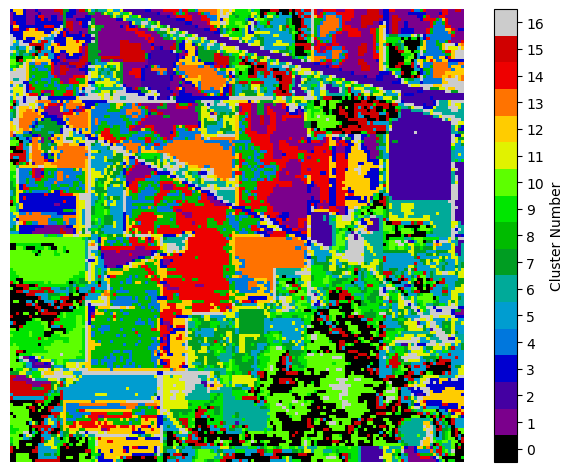

In [31]:
# k-means clustering using the components generated in the previous cell
clusterer = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = clusterer.fit_predict(selected_components_tsne) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

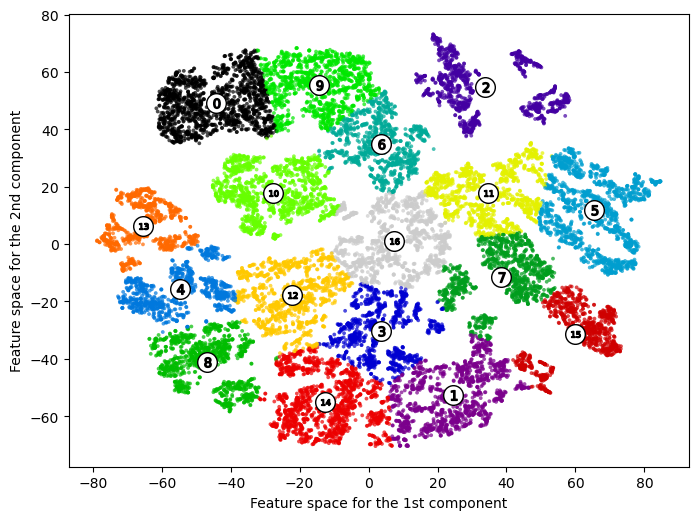

In [32]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components_tsne[:, 0],
    selected_components_tsne[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = clusterer.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

# plt.title('Clustered Data')
plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [33]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_tsne = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialize the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components_tsne)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components_tsne, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components_tsne, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components_tsne, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_tsne.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_tsne.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.409065,23355.825835,0.761361,0.373761,0.253164,0.301863,0.701927,0.069094,0.682772,0.300160
16.0,0.403996,23365.618791,0.771491,0.372524,0.246366,0.296587,0.701019,0.060959,0.680512,0.294772
17.0,0.404559,23363.586269,0.762005,0.365042,0.236692,0.287178,0.700965,0.056960,0.666845,0.285238
18.0,0.393024,23532.971755,0.796684,0.378956,0.240516,0.294267,0.701635,0.054375,0.692263,0.292250
19.0,0.403890,24021.676222,0.754011,0.380952,0.237853,0.292857,0.703571,0.057606,0.695908,0.290737


# Isomap Embedding

In [34]:
isomap = Isomap(n_jobs=-1)
selected_components_isomap = isomap.fit_transform(data_reshaped)

print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected components: {selected_components_isomap.shape[1]}')

Number of spectral bands: 200
Number of selected components: 2


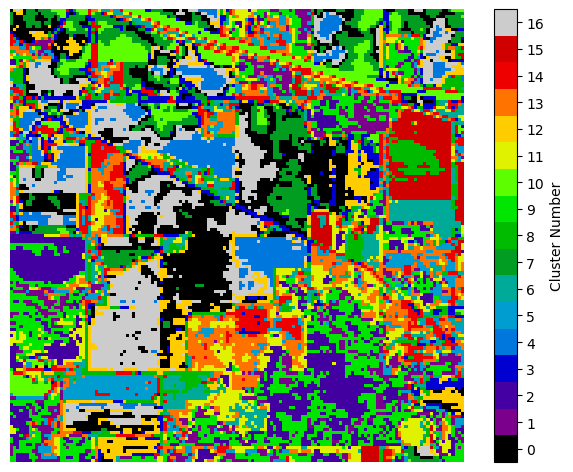

In [35]:
# k-means clustering using the components generated in the previous cell
clusterer = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = clusterer.fit_predict(selected_components_isomap) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

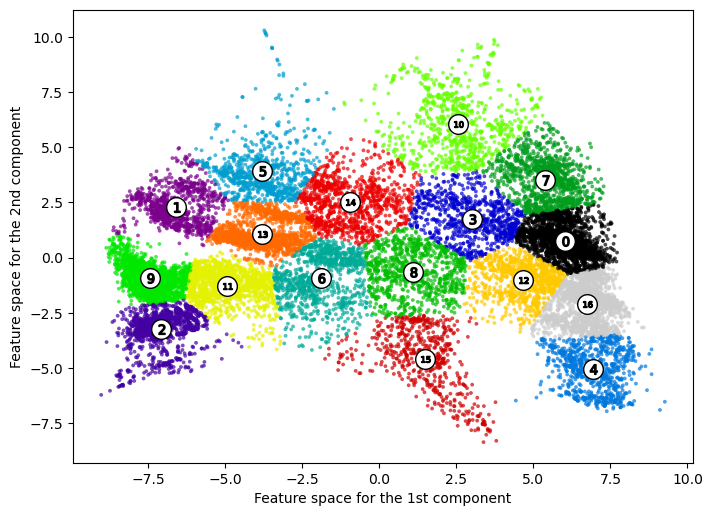

In [36]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components_isomap[:, 0],
    selected_components_isomap[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = clusterer.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

# plt.title('Clustered Data')
plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [37]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_isomap = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialize the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components_isomap)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components_isomap, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components_isomap, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components_isomap, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_isomap.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_isomap.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.409222,34855.197467,0.747520,0.354229,0.245335,0.289893,0.693135,0.052050,0.647091,0.288137
16.0,0.417073,35020.644973,0.746026,0.360793,0.243956,0.291088,0.696022,0.055363,0.659082,0.289235
17.0,0.418777,35426.544265,0.738772,0.366962,0.242379,0.291935,0.696792,0.052071,0.670352,0.289986
18.0,0.407196,35362.558622,0.742795,0.365589,0.235986,0.286826,0.698508,0.051508,0.667844,0.284768
19.0,0.409959,35597.431940,0.744554,0.368484,0.233379,0.285768,0.698737,0.048136,0.673132,0.283609


# Spectral Embedding (Laplacian Eigenmaps)

In [38]:
spec_embed = SpectralEmbedding(n_jobs=-1)
selected_components_spec_embed = spec_embed.fit_transform(data_reshaped)

print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected components: {selected_components_spec_embed.shape[1]}')

Number of spectral bands: 200
Number of selected components: 2


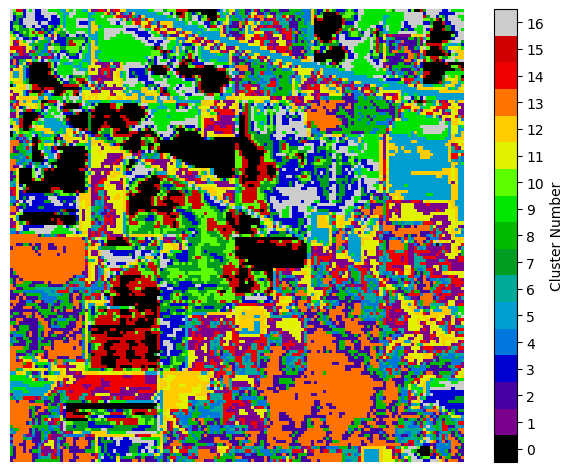

In [39]:
# k-means clustering using the components generated in the previous cell
clusterer = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = clusterer.fit_predict(selected_components_spec_embed) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

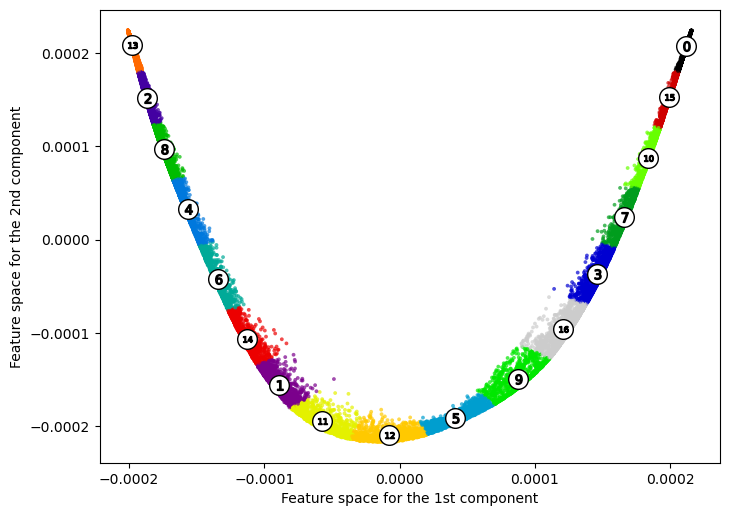

In [40]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components_spec_embed[:, 0],
    selected_components_spec_embed[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = clusterer.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

# plt.title('Clustered Data')
plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [41]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_spec_embed = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialize the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components_spec_embed)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components_spec_embed, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components_spec_embed, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components_spec_embed, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_spec_embed.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_spec_embed.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.549671,181126.629105,0.516387,0.325037,0.222002,0.263816,0.694387,0.049510,0.593766,0.262011
16.0,0.541413,190195.005575,0.521298,0.326533,0.217803,0.261309,0.696931,0.051965,0.596498,0.259393
17.0,0.539195,201440.505830,0.521901,0.327301,0.213753,0.258612,0.696331,0.045617,0.597900,0.256585
18.0,0.535658,208624.247710,0.530042,0.327562,0.210210,0.256082,0.697345,0.045769,0.598378,0.253942
19.0,0.535159,219755.218005,0.529576,0.328174,0.206838,0.253747,0.697226,0.041745,0.599496,0.251497


# Modified Locally Linear Embedding (Modified LLE)

In [46]:
lle_mod = LocallyLinearEmbedding(method='modified', n_jobs=-1,random_state=1)
selected_components_lle_mod = lle_mod.fit_transform(data_reshaped)

print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected components: {selected_components_lle_mod.shape[1]}')

Number of spectral bands: 200
Number of selected components: 2


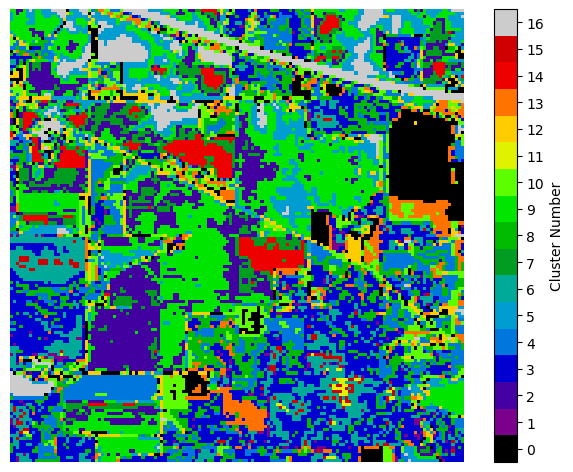

In [47]:
# k-means clustering using the components generated in the previous cell
clusterer = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = clusterer.fit_predict(selected_components_lle_mod) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

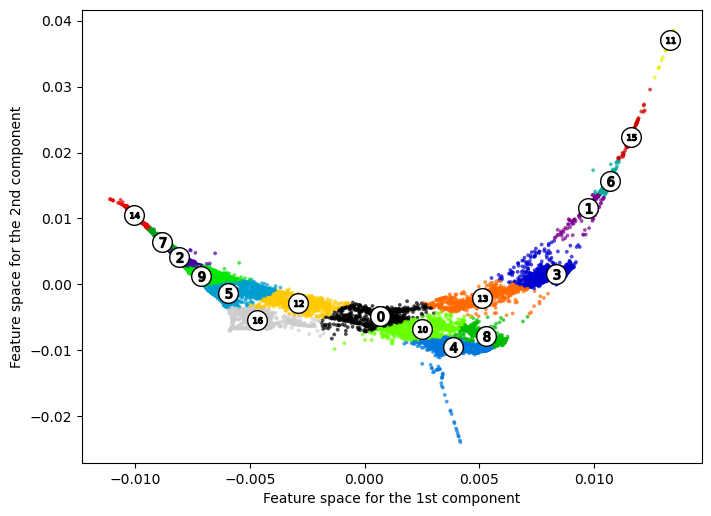

In [48]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components_lle_mod[:, 0],
    selected_components_lle_mod[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = clusterer.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

# plt.title('Clustered Data')
plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [49]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_lle_mod = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialize the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components_lle_mod)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components_lle_mod, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components_lle_mod, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components_lle_mod, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_lle_mod.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_lle_mod.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.547603,99149.297194,0.594993,0.327690,0.239163,0.276513,0.690439,0.060604,0.598611,0.274688
16.0,0.556551,101745.510151,0.577636,0.332739,0.238400,0.277778,0.690841,0.059514,0.607835,0.275843
17.0,0.554568,104728.880517,0.581413,0.335549,0.237983,0.278467,0.690880,0.058376,0.612969,0.276419
18.0,0.531296,107634.061877,0.606656,0.339638,0.232357,0.275937,0.693006,0.052402,0.620437,0.273796
19.0,0.534893,108916.057444,0.602205,0.349494,0.236235,0.281914,0.690489,0.045517,0.638443,0.279679


# Uniform Manifold Approximation and Projection (UMAP)

In [8]:
umap = umap.UMAP(n_jobs=-1,random_state=1)
selected_components_umap = umap.fit_transform(data_reshaped)

print('Number of spectral bands:', data_reshaped.shape[1])
print(f'Number of selected components: {selected_components_umap.shape[1]}')

Number of spectral bands: 200
Number of selected components: 2


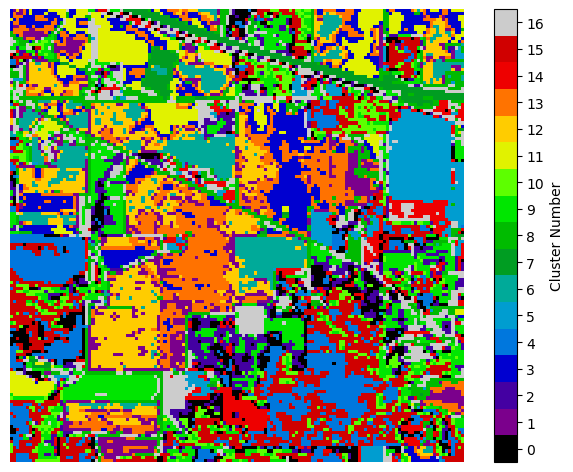

In [9]:
# k-means clustering using the components generated in the previous cell
clusterer = cluster.KMeans(n_clusters=17, random_state=1) # create an object of the classifier
labels = clusterer.fit_predict(selected_components_umap) # train
labels_2d = labels.reshape(data_array[:, :, 0].shape) # reshape the labels to a 3D array (single band)
plot_data(labels_2d, 17)

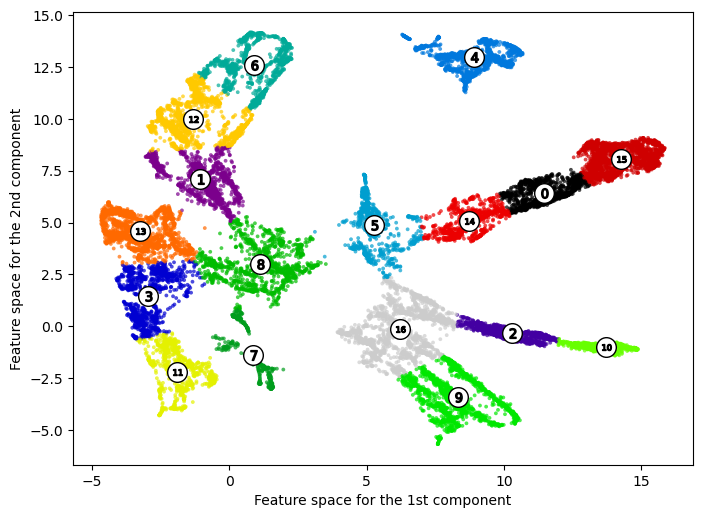

In [10]:
fig = plt.figure(figsize=(8, 6), dpi=100)

n_clusters = 16
colors = cm.nipy_spectral(labels / n_clusters)

plt.scatter(
    selected_components_umap[:, 0],
    selected_components_umap[:, 1],
    marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
)

# labeling the clusters
centers = clusterer.cluster_centers_

# draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker='o', s=200, alpha=1, c='white', edgecolor='k'
)

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' %i, s=50, alpha=1, edgecolor='k')

# plt.title('Clustered Data')
plt.xlabel('Feature space for the 1st component')
plt.ylabel('Feature space for the 2nd component')

plt.show()

In [11]:
# calculate different performance metrics for various numbers of clusters
range_n_clusters = list(range(15, 20))
columns = ['Number of clusters', 'Average Silhouette score', 'Calinski-Harabasz score', 'Davies-Bouldin score',
           'Homogeneity score', 'Completeness score', 'V-measure', 'Rand index', 'Adjusted Rand index',
           'Mutual Information score', 'Adjusted Mutual Information score']
scores_umap = pd.DataFrame(np.zeros((len(range_n_clusters), len(columns))), columns=columns)

# 3D plots and different scores
for count, n_clusters in enumerate(range_n_clusters):
    # initialize the clusterer with n_clusters value and a random generator
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
    labels = clusterer.fit_predict(selected_components_umap)

    # the silhouette_score gives the average value for all the samples.
    # this gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(selected_components_umap, labels)
    
    scores_temp = [n_clusters, silhouette_avg,
                   # the resulting Calinski-Harabasz score.
                   calinski_harabasz_score(selected_components_umap, labels),
                   # the resulting Davies-Bouldin score.
                   # the minimum score is zero, and the lower values the better clustering performance.
                   davies_bouldin_score(selected_components_umap, labels),
                   # homogeneity score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling.
                   homogeneity_score(gt_reshaped, labels),
                   # completeness score between 0.0 and 1.0. 1.0 stands for perfectly complete labeling.
                   completeness_score(gt_reshaped, labels),
                   # v-measure is the harmonic mean of the first two.
                   v_measure_score(gt_reshaped, labels),
                   # similarity score between 0.0 and 1.0, inclusive, 1.0 stands for perfect match.
                   rand_score(gt_reshaped, labels),
                   # similarity score between -1.0 and 1.0. Random labelings have an ARI close to 0.0. 1.0 stands for perfect match.
                   adjusted_rand_score(gt_reshaped, labels),
                   # mutual information, a non-negative value, measured in nats using the natural logarithm.
                   mutual_info_score(gt_reshaped, labels),
                   # the AMI returns a value of 1 when the two partitions are identical (ie perfectly matched).
                   # random partitions (independent labellings) have an expected AMI around 0 on average
                   # hence can be negative. The value is in adjusted nats (based on the natural logarithm).
                   adjusted_mutual_info_score(gt_reshaped, labels)
                   ]
    scores_umap.iloc[[count]] = scores_temp
    
from IPython.display import display, HTML
display(HTML(scores_umap.to_html(index=False)))

Number of clusters,Average Silhouette score,Calinski-Harabasz score,Davies-Bouldin score,Homogeneity score,Completeness score,V-measure,Rand index,Adjusted Rand index,Mutual Information score,Adjusted Mutual Information score
15.0,0.525824,52522.968959,0.629833,0.360990,0.246226,0.292763,0.698912,0.062716,0.659443,0.291030
16.0,0.517220,51859.632561,0.647702,0.370028,0.246708,0.296039,0.699421,0.059529,0.675953,0.294214
17.0,0.522414,54324.774333,0.643397,0.375247,0.246815,0.297773,0.699057,0.056535,0.685486,0.295846
18.0,0.513091,54963.170355,0.665117,0.382633,0.246126,0.299561,0.699371,0.052563,0.698979,0.297544
19.0,0.517043,56099.192701,0.674695,0.387932,0.244657,0.300069,0.701377,0.054760,0.708660,0.297959
